In [ ]:
!pip3 install costcla
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import joblib
import os
from google.colab import drive
from costcla.models import CostSensitiveRandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.ensemble import BalancedBaggingClassifier
from warnings import simplefilter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.linear_model import LogisticRegression

simplefilter(action='ignore', category=FutureWarning)

     |████████████████████████████████| 4.0MB 26.1MB/s 
  Created wheel for pyea: filename=pyea-0.2-cp37-none-any.whl size=6017 sha256=47b19151c1910e1429272fb750402c607b215fd05324296dd9bbb3ce1f9099f0
  Stored in directory: /root/.cache/pip/wheels/3c/bf/6e/06f8b0ed23cbc1fe956f8b6756535cb36f0b68c2f0f2342178
Successfully built pyea


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

In [ ]:
# Συνδέομαι στο google drive για να μπορώ να αποθηκεύω και να ανακτώ μοντέλα από εκεί
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Καθορίζω την διαδρομή στο google drive και φορτώνω στην μνήμη το σύνολο των δεδομένων
path = 'drive/My Drive/bank_credit'
dt = pd.read_csv(os.path.join(path, 'creditcard.csv'))

In [ ]:
# Επισκόπηση λίγων δεδομένων των δύο κλάσεων
a = dt.loc[dt['Class']==0].sample(3)
b = dt.loc[dt['Class']==1].sample(5)
c = pd.concat([a,b])
c

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
241135,150900.0,0.432387,0.616059,-1.147939,-0.400000,1.002821,1.301899,-0.847739,-2.399489,0.011474,-0.973300,-0.789863,-0.094419,-1.230266,1.247610,1.467479,-0.839118,0.360320,-1.012311,-1.245505,0.342875,-0.898298,1.592172,0.065098,-0.557376,-0.069107,-0.059430,0.258765,0.354723,1.00,0
113427,73061.0,-0.633276,1.247623,1.463812,-0.092242,-0.097017,-0.898550,0.725302,-0.075149,-0.253987,-0.014818,-0.325860,0.127480,0.351519,0.007642,0.828154,0.164323,-0.422147,-0.406487,-0.017088,0.243676,-0.255290,-0.591011,-0.016809,0.365708,-0.131541,0.075058,0.374375,0.181537,4.49,0
268931,163451.0,1.881558,-0.011692,-1.533286,0.760751,-0.299977,-2.065597,0.487653,-0.462978,0.400562,-0.424373,0.310236,0.117702,-0.810417,-0.670573,0.076706,-0.097961,1.097951,-0.529119,-0.366950,-0.117395,-0.140492,-0.426166,0.262835,0.846320,-0.267819,0.417260,-0.094322,-0.023146,70.20,0
27749,34687.0,-0.860827,3.131790,-5.052968,5.420941,-2.494141,-1.811287,-5.479117,1.189472,-3.908206,-7.060746,4.729974,-8.629054,1.178798,-11.182063,0.445243,-6.532982,-13.389251,-4.480413,0.432054,1.085760,1.192694,0.090356,-0.341881,-0.215924,1.053032,0.271139,1.373300,0.691195,19.02,1
20198,30852.0,-2.830984,0.885657,1.199930,2.861292,0.321669,0.289966,1.767760,-2.451050,0.069736,3.245086,0.675288,-0.677096,-0.222741,-0.913787,1.603332,-1.024502,0.022045,-0.940685,0.484759,-1.016923,0.546589,0.334971,0.172106,0.623590,-0.527114,-0.079215,-2.532445,0.311177,104.81,1
53591,46057.0,-1.309441,1.786495,-1.371070,1.214335,-0.336642,-1.390120,-1.709109,0.667748,-1.699809,-3.843911,2.962599,-3.956045,-1.539232,-4.634631,-0.248403,-2.058551,-5.635494,-0.775271,-0.239310,0.253464,0.533521,-0.022180,-0.299556,-0.226416,0.364360,-0.475102,0.571426,0.293426,1.00,1
42936,41305.0,-12.980943,6.720508,-13.455636,8.698610,-11.479552,-2.681519,-14.019291,8.218191,-7.930900,-12.695947,5.589362,-11.960866,1.538671,-9.887214,0.633979,-11.350244,-21.710188,-8.859452,3.629714,-0.843303,2.549628,-0.532228,-0.235096,0.673209,0.226598,-0.006168,-1.185696,-0.747361,59.68,1
248971,154181.0,-0.549615,2.219075,-3.522024,0.236995,1.087469,-1.235530,-0.279313,0.514361,-1.849927,-3.443819,2.214000,-1.689836,0.498438,-4.393634,-1.270841,-1.176629,-1.859739,-0.049419,0.385263,0.126518,0.364130,0.210428,-0.366019,0.015803,0.349212,0.647302,0.171929,0.117188,0.76,1


In [ ]:
# Περιγραφή δεδομένων
print(dt.columns)

print(30*'-')
for column in ['Time', 'Amount', 'Class']:
    print(dt[column].describe())
    print(30*'-')
    print(dt[column])
    print(50*'-')

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
------------------------------
count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64
------------------------------
0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64
--------------------------------------------------
count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.16500

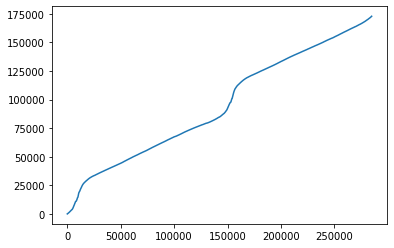

In [ ]:
# Γραφική απεικόνιση του χαρακτηριστικού Time
plt.plot(range(len(dt)), dt['Time'])

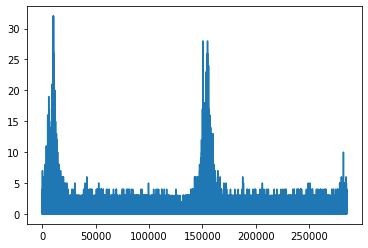

In [ ]:
# Γραφική απεικόνιση των διαστημάτων μεταξύ των διαδοχικών δεδομένων
# Φαίνονται οι ώρες αιχμής και κυρίως οι ώρες που το σύστημα δέχεται μικρό φόρτο
s = dt['Time'][1:].append(dt['Time'][-1:])
s = s.reset_index(drop=True)
s = s - dt['Time']
plt.plot(range(len(dt)), s)

In [ ]:
# Δημιουργώ ένα χαρακτηριστικό πυκνότητας συναλλαγών (Density) και ένα πραγματικής ώρας (Actual Time)
# θεωρώντας ότι μπορεί να υπάρχει κάποια συσχέτιση με τις κακόβουλες κινήσεις
# Ενώ παράλληλα διαγράφω το χαρακτηριστικό Time
period = 30 * 60 # secs
half_period = int(period / 2)
a = np.histogram(dt['Time'], bins=np.linspace(0, 172800, 172801))[0]

density48h = [np.mean(a[[j % 172800 for j in range(-half_period, +half_period)]])]
for i in range(1, len(a)):
  density48h.append(density48h[-1] + (a[(i + half_period - 1) % 172800] - a[(i - half_period) % 172800]) / period)

density48h = np.array(density48h)
density48h = density48h / density48h.max()

dt['Density'] = density48h[dt['Time'].astype(int).values]
dt['Density'].reset_index(drop=True)
dt['Actual_Time'] = dt['Time'].apply(lambda x: np.mod(x, 86400) / 86400)

dt.drop('Time', inplace=True, axis='columns')

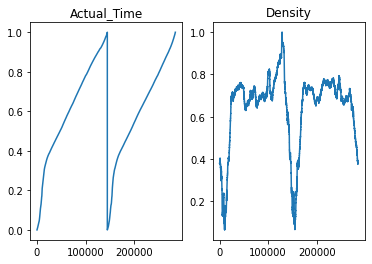

In [ ]:
# Γραφική απεικόνιση των δύο νέων χαρακτηριστικών
plt.subplot(121)
dt['Actual_Time'].plot(title='Actual_Time')
plt.subplot(122)
dt['Density'].plot(title='Density')

In [ ]:
# Μετατρέπω το χαρακτηριστικό Amount με λογαριθμική κανονικοποίηση
amounts = dt['Amount'].copy()
dt['Amount'] = np.log(dt['Amount']+2)
dt['Amount']

0         5.021377
1         1.545433
2         5.941907
3         4.832306
4         4.276527
            ...   
284802    1.018847
284803    3.288029
284804    4.246779
284805    2.484907
284806    5.389072
Name: Amount, Length: 284807, dtype: float64

In [ ]:
# Χωρίζω το σύνολο δεδομένων σε εκπαίδευσης, επικύρωσης και ελέγχου
seed = 0

x_tr, x_te, y_tr, y_te = train_test_split(dt.loc[:, dt.columns != 'Class'], dt['Class'], test_size=.3, random_state=seed)

va_size = int(len(x_tr) * .2)
x_va, x_tr = x_tr[:va_size], x_tr[va_size:]
y_va, y_tr = y_tr[:va_size], y_tr[va_size:]

print(x_tr.shape, x_va.shape, x_te.shape)

(159492, 31) (39872, 31) (85443, 31)


In [ ]:
# Δημιουργία του πίνακα κόστους

t_nf = 0
t_fr = 0
f_nf = 5
f_fr = 1

#    (classes)    NF    FR
cost_matrix = [[ t_nf, f_nf], # NF (Predictions)
               [ f_fr, t_fr]] # FR

cost_matrix = pd.DataFrame(cost_matrix, index=['Prediction NF', 'Prediction FR'])
cost_matrix.columns = ['Class NF', 'Class FR']

#                FN    FP    TN    TP
cost_matrix_ = [f_nf, f_fr, t_nf, t_fr]

def full_cm(lst, num):
    return np.array([lst] * num)

'ok'

'ok'

In [ ]:
# Τρέχω ένα Grid Search για να βρω τις καλύτερες παραμέτρους για ένα γραμμικό μοντέλο SVM

# grid = GridSearchCV(SVC(), param_grid=dict(gamma=np.logspace(-3, 2, 6),
#                                            C=np.logspace(-1, 4, 6)),
#                     cv=StratifiedShuffleSplit(n_splits=3, test_size=0.95, random_state=seed),
#                     verbose=255,
#                     scoring="f1")
# grid.fit(x_tr, y_tr)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid.best_params_, grid.best_score_))

In [ ]:
# Αφού βρήκα τις καλύτερες παραμέτρους για το SVM μοντέλο οι οποίες είναι οι εξής:
# {'C': 10.0, 'gamma': 0.001} with a score of 0.58
# εκπαίδευσα το μοντέλο και το αποθήκευσα εκπαιδευμένο για να μπορώ να το ανακαλώ άμεσα
# και να μην χρειάζεται να εκπαιδεύω συνεχώς σε κάθε νέα εκτέλεση του notebook

# svc = SVC(kernel='rbf',
#           C=grid.best_params_['C'],
#           gamma=grid.best_params_['gamma'],
#           verbose=1)

# svc.fit(x_tr, y_tr)

# joblib.dump(svc, path + '/svc_C'+str(grid.best_params_['C'])+'_gamma'+(grid.best_params_['gamma'])+'.joblib')

In [ ]:
# Ανακαλώ στην μνήμη το εκπαιδευμένο μοντέλο SVM που έχω αποθηκεύσει και κάνω προβλέψεις για το σύνολο ελέγχου

svc = joblib.load(path + '/svc_C10.0_gamma0.001.joblib')
# y_pred = svc.predict(x_va)
y_pred = svc.predict(x_te)

# print(confusion_matrix(y_va, y_pred))
print(confusion_matrix(y_te, y_pred).T)
print()
# print(classification_report(y_va, y_pred))
print(classification_report(y_te, y_pred))

print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_pred).T))

[[85285    39]
 [   11   108]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.91      0.73      0.81       147

    accuracy                           1.00     85443
   macro avg       0.95      0.87      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 206


In [ ]:
# Τρέχω ένα Grid Search για να βρω τις καλύτερες παραμέτρους για ένα μοντέλο Random Forest

# grid2 = GridSearchCV(RandomForestClassifier(),
#                      param_grid=dict(n_estimators=(10, 50, 100, 200, 300),
#                                      criterion=('entropy', 'gini')),
#                      cv=StratifiedShuffleSplit(n_splits=3, test_size=0.95, random_state=seed),
#                      verbose=10,
#                      scoring="f1")
# grid2.fit(x_tr, y_tr)

# print("The best parameters are %s with a score of %0.2f"
#       % (grid2.best_params_, grid2.best_score_))

In [ ]:
# Αφού βρήκα τις καλύτερες παραμέτρους για το Random Forest μοντέλο μου οι οποίες είναι οι εξής:
# {'criterion': 'gini', 'n_estimators': 200} with a score of 1.00
# εκπαίδευσα το μοντέλο και το αποθήκευσα εκπαιδευμένο για να μπορώ να το ανακαλώ άμεσα
# και να μην χρειάζεται να εκπαιδεύω συνεχώς σε κάθε νέα εκτέλεση του notebook

# rf = RandomForestClassifier(n_estimators=200,
#                             random_state=seed,
#                             criterion='gini',
#                             verbose=1)

# rf.fit(x_tr, y_tr)

# joblib.dump(svc, path + '/rf_est'+str(grid.best_params_['n_estimators'])+'_crit'+(grid.best_params_['criterion'])+'.joblib')

In [ ]:
# Ανακαλώ στην μνήμη το εκπαιδευμένο μοντέλο Random Forest που έχω αποθηκεύσει και κάνω προβλέψεις για το σύνολο ελέγχου

rf = joblib.load(path + '/rf_est200_critGini.joblib')

# y_pred = rf.predict(x_va)
y_pred = rf.predict(x_te)

# print(confusion_matrix(y_va, y_pred))
print(confusion_matrix(y_te, y_pred).T)
print()
# print(classification_report(y_va, y_pred))
print(classification_report(y_te, y_pred))

print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_pred).T))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.5s finished


[[85289    36]
 [    7   111]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.76      0.84       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 187


In [ ]:
# Δημιουργία Cost Sensitive Random Forest ταξινομητή από την βιβλιοθήκη costcla
# παραμετροποίηση του μοντέλου με τις καλύτερες παραμέτρους που βρέθηκαν προηγουμένως για το απλό μοντέλο
# Εκπαίδευση του μοντέλου με διαφορετικούς πίνακες κόστους και
# αποθήκευση των εκπαιδευμένων μοντέλων ώστε να μην χρειάζεται να εκπαιδεύονται σε κάθε νέα εκτέλεση του notebook

# for i in [100, 500, 1000, 1500, 2000]:
#   cost_matrix_ = [1, i, 0, 0]
#   cost_forest = CostSensitiveRandomForestClassifier(n_estimators=200, verbose=True, n_jobs=4)
#   cost_forest.fit(x_tr.to_numpy(), y_tr.to_numpy(), full_cm(cost_matrix_, len(y_tr)))
#   joblib.dump(cost_forest, path + '/csrf_est_200_crit_gini_1_'+str(i)+'.joblib')

In [ ]:
# Ανακαλώ τα αποθηκευμένα μοντέλα Cost Sensitive Random Forest
# και κάνω προβλέψεις στο σύνολο ελέγχου

y_preds = []
rate = [100, 500, 1000, 1500, 2000]
for i in rate:
  cost_forest = joblib.load(path + '/csrf_est_200_crit_gini_1_'+str(i)+'.joblib')

  # y_preds.append(cost_forest.predict(x_va.to_numpy()))
  y_preds.append(cost_forest.predict(x_te.to_numpy()))

  # print(confusion_matrix(y_va, y_preds[-1]).Τ)
  print(confusion_matrix(y_te, y_preds[-1]).T)
  print()
  # print(classification_report(y_va, y_preds[-1]))
  print(classification_report(y_te, y_preds[-1]))

  # print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_va, y_preds[-1]).T))
  print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_preds[-1]).T))
  print('-' * 50)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   17.7s remaining:   17.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   18.3s finished


[[85282    35]
 [   14   112]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.76      0.82       147

    accuracy                           1.00     85443
   macro avg       0.94      0.88      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 189
--------------------------------------------------


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   18.1s remaining:   18.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   18.7s finished


[[85278    29]
 [   18   118]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.80      0.83       147

    accuracy                           1.00     85443
   macro avg       0.93      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 163
--------------------------------------------------


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   19.4s remaining:   19.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.2s finished


[[85106    26]
 [  190   121]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.39      0.82      0.53       147

    accuracy                           1.00     85443
   macro avg       0.69      0.91      0.76     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 320
--------------------------------------------------


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   19.6s remaining:   19.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.7s finished


[[84839    24]
 [  457   123]]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.21      0.84      0.34       147

    accuracy                           0.99     85443
   macro avg       0.61      0.92      0.67     85443
weighted avg       1.00      0.99      1.00     85443

Κόστος 577
--------------------------------------------------


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   20.0s remaining:   20.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   20.7s finished


[[84488    22]
 [  808   125]]

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85296
           1       0.13      0.85      0.23       147

    accuracy                           0.99     85443
   macro avg       0.57      0.92      0.61     85443
weighted avg       1.00      0.99      0.99     85443

Κόστος 918
--------------------------------------------------


In [ ]:
# Δημιουργία ενός αριθμού από υποσύνολα δεδομένων τα οποία έχουν ίσο αριθμό παραδειγμάτων των δύο κλάσεων.
# Με αυτά εκπαιδεύονται μοντέλα Random Forest και η έκδσοση απόφασης γίνεται με ψηφοφορία.
# Τα bagging μοντέλα εκπαιδεύονται και αποθηκεύονται, ώστε να μην χρειάζεται σε κάθε εκτέλεση του notebook

# y0 = y_tr[y_tr==0]
# x0 = x_tr[y_tr==0]

# y1 = y_tr[y_tr==1]
# x1 = x_tr[y_tr==1]

# ln = len(y1)
# number_of_subsets = [20, 50, 100, 200]


# for i in number_of_subsets:
#   print(f'{i}...')
#   model = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=200), n_estimators=i)
#   model.fit(x_tr, y_tr)
#   joblib.dump(model, path + '/bal_bag_rf_200_gini' + str(i) + '.joblib')

#   print(f'iso {i}...')
#   mod_iso = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=200), n_estimators=i)
#   model_iso = CalibratedClassifierCV(base_estimator=mod_iso, cv=3, method='isotonic')
#   model_iso.fit(x_tr, y_tr)
#   joblib.dump(model_iso, path + '/iso_bal_bag_rf_200_gini' + str(i) + '.joblib')

#   print(f'sigm {i}...')
#   mod_sigm = BalancedBaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=200), n_estimators=i)
#   model_sigm = CalibratedClassifierCV(base_estimator=mod_sigm, cv=3, method='sigmoid')
#   model_sigm.fit(x_tr, y_tr)
#   joblib.dump(model_sigm, path + '/sigm_bal_bag_rf_200_gini' + str(i) + '.joblib')

In [ ]:
# Ανάκληση των εκπαιδευμένων μοντέλων και υπολογισμός προβλέψεων στο σύνολο ελέγχου

number_of_subsets = [20, 50, 100, 200]

for i in number_of_subsets:
  model = joblib.load(path + '/bal_bag_rf_200_gini' + str(i) + '.joblib')
  model_iso = joblib.load(path + '/iso_bal_bag_rf_200_gini' + str(i) + '.joblib')
  model_sigm = joblib.load(path + '/sigm_bal_bag_rf_200_gini' + str(i) + '.joblib')

  y_preds = model.predict_proba(x_te.to_numpy())
  y_preds = [(t_nf * i + f_nf * j, t_fr * j + f_fr * i) for i, j in y_preds]
  y_preds = [0 if i < j else 1 for i, j in y_preds]

  print(f'No of balanced models {i}')
  print('Not Calibrated')
  print(confusion_matrix(y_te, y_preds).T)
  print()
  print(classification_report(y_te, y_preds))

  print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_preds).T))
  print('-' * 50)

  print(f'Isotonic {i}')
  y_preds = model_iso.predict_proba(x_te.to_numpy())
  y_preds = [(t_nf * i + f_nf * j, t_fr * j + f_fr * i) for i, j in y_preds]
  y_preds = [0 if i < j else 1 for i, j in y_preds]

  print(confusion_matrix(y_te, y_preds).T)
  print()
  print(classification_report(y_te, y_preds))

  print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_preds).T))
  print('-' * 50)

  print(f'Sigmoid {i}')
  y_preds = model_sigm.predict_proba(x_te.to_numpy())
  y_preds = [(t_nf * i + f_nf * j, t_fr * j + f_fr * i) for i, j in y_preds]
  y_preds = [0 if i < j else 1 for i, j in y_preds]

  print(confusion_matrix(y_te, y_preds).T)
  print()
  print(classification_report(y_te, y_preds))

  print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, y_preds).T))
  print('-' * 70)


No of balanced models 20
Not Calibrated
[[69421     7]
 [15875   140]]

              precision    recall  f1-score   support

           0       1.00      0.81      0.90     85296
           1       0.01      0.95      0.02       147

    accuracy                           0.81     85443
   macro avg       0.50      0.88      0.46     85443
weighted avg       1.00      0.81      0.90     85443

Κόστος 15910
--------------------------------------------------
Isotonic 20
[[85268    26]
 [   28   121]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.81      0.82      0.82       147

    accuracy                           1.00     85443
   macro avg       0.91      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 158
--------------------------------------------------
Sigmoid 20
[[85256    26]
 [   40   121]]

              precision    recall  f1-score   support

      

In [32]:

models = [LogisticRegression(max_iter=1000), RandomForestClassifier(n_estimators=200), SVC(kernel='rbf')]

unders = [RandomUnderSampler(sampling_strategy=0.03),
        RandomUnderSampler(sampling_strategy=0.02),
        RandomUnderSampler(sampling_strategy=0.01),
        RandomUnderSampler(sampling_strategy=0.005)]

overs = [SMOTE(.05),
          SMOTE(.10),
          SMOTE(.20),
          RandomOverSampler(sampling_strategy=0.20),
          RandomOverSampler(sampling_strategy=0.10),
          RandomOverSampler(sampling_strategy=0.05)]

for model in models:
  print(f'Μοντέλο: {model.__class__().__str__()}')
  model.fit(x_tr, y_tr)

  preds = model.predict(x_te)

  print(f'Κλάση 0, {(y_tr==0).sum()}')
  print(f'Κλάση 1, {(y_tr==1).sum()}')

  print(confusion_matrix(y_te, preds).T)
  print()
  print(classification_report(y_te, preds))
  print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, preds).T))
  print(50*'-')
  # under = RandomUnderSampler(sampling_strategy=0.01)
  for under in unders:
    x_US, y_US = under.fit_resample(x_tr, y_tr)

    print(f'Κλάση 0, {(y_US==0).sum()}')
    print(f'Κλάση 1, {(y_US==1).sum()}')

    model.fit(x_US, y_US)

    preds = model.predict(x_te)

    print(confusion_matrix(y_te, preds).T)
    print()
    print(classification_report(y_te, preds))
    print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, preds).T))
    print(50*'-')
    # over = SMOTE(.025)
    for over in overs:
      x_SM, y_SM = over.fit_resample(x_US, y_US)

      print(f'Κλάση 0, {(y_SM==0).sum()}')
      print(f'Κλάση 1, {(y_SM==1).sum()}')

      model.fit(x_SM, y_SM)

      preds = model.predict(x_te)

      print(confusion_matrix(y_te, preds).T)
      print()
      print(classification_report(y_te, preds))
      print("Κόστος", np.sum(cost_matrix.values * confusion_matrix(y_te, preds).T))
      print(50*'-')
  
  print(70*'-')


Μοντέλο: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Κλάση 0, 159214
Κλάση 1, 278
[[85285    55]
 [   11    92]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.63      0.74       147

    accuracy                           1.00     85443
   macro avg       0.95      0.81      0.87     85443
weighted avg       1.00      1.00      1.00     85443

Κόστος 286
--------------------------------------------------
Κλάση 0, 9266
Κλάση 1, 278
[[85250    28]
 [   46   119]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.72      0.81      0.76    